# 07 经典 CNN 架构与 ResNet 深入

> 从历史演进到残差网络的核心原理

---

**本章重点**：ResNet 是现代深度学习的基石，我们将深入理解其原理并从零实现。

## 📚 学习目标

- [ ] 了解 CNN 架构的演进历史（5分钟速览）
- [ ] **深入理解残差连接的数学原理**
- [ ] **从零实现 ResNet-18**
- [ ] 通过对比实验验证残差连接的效果
- [ ] 了解现代架构趋势

In [4]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import warnings
warnings.filterwarnings('default')

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# 设置设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用设备: {device}")

使用设备: cpu


---

# Part 1: 历史概览（5分钟速览）

## 📜 CNN 发展时间线

```
1998: LeNet-5      → 第一个成功的 CNN，银行支票识别
2012: AlexNet      → ReLU + Dropout，开启深度学习时代
2014: VGG          → 3×3 卷积堆叠，证明"更深更好"
2015: ResNet ⭐    → 残差连接，突破深度限制（152层）
2019: EfficientNet → 复合缩放，效率与准确率兼顾
2020: ViT          → Transformer 进入视觉领域
```

## 早期架构速览

| 架构 | 年份 | 核心创新 | 历史意义 |
|------|------|----------|----------|
| **LeNet** | 1998 | 卷积 + 池化 | 证明 CNN 可行，用于银行支票识别 |
| **AlexNet** | 2012 | ReLU + Dropout + GPU | ImageNet 夺冠，开启深度学习时代 |
| **VGG** | 2014 | 3×3 小卷积堆叠 | 证明深度有效，但遇到瓶颈 |

### 问题出现了：更深一定更好吗？

VGG 之后，研究者发现一个奇怪的现象：

> **当网络加深到一定程度后，训练误差反而上升！**
> 
> 这不是过拟合（过拟合是训练好、测试差），而是**训练本身就变差了**。

这个问题促使了 ResNet 的诞生。

---

# Part 2: ResNet 深入讲解 ⭐

## 2.1 深度网络的困境

### 退化问题（Degradation Problem）

ResNet 论文中展示了一个反直觉的现象：

/var/folders/lp/_34q95f139j8jppsz3tx5gyr0000gn/T/ipykernel_86525/2712220457.py:35: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from current font.
  plt.tight_layout()
/Users/lyh/miniconda3/envs/ml_env/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


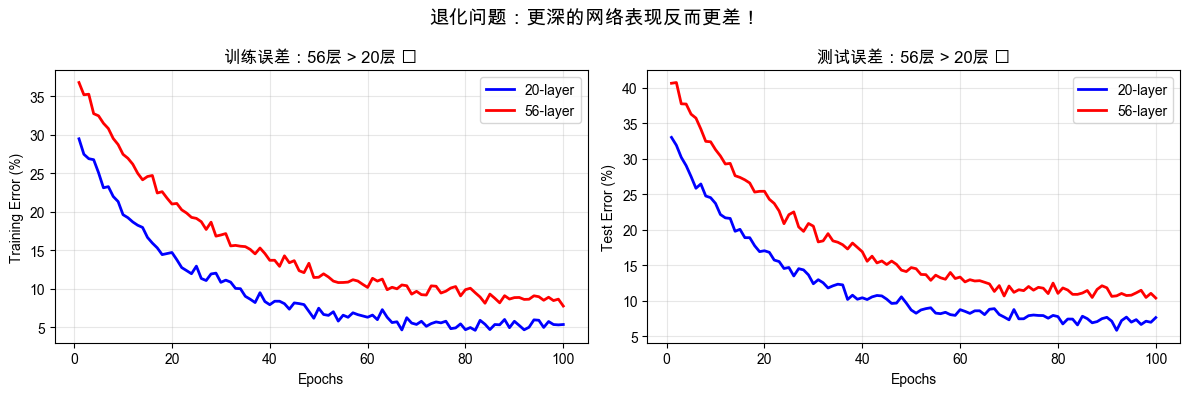

💡 关键发现：
   - 这不是过拟合（过拟合是训练好、测试差）
   - 而是训练误差本身就更高
   - 说明优化本身遇到了困难


In [5]:
# 模拟 ResNet 论文中的退化现象
# 数据来源：原论文 Figure 1

epochs = np.arange(1, 101)

# 20层网络
train_error_20 = 25 * np.exp(-0.05 * epochs) + 5 + np.random.randn(100) * 0.5
test_error_20 = 27 * np.exp(-0.05 * epochs) + 7 + np.random.randn(100) * 0.5

# 56层网络（更深反而更差！）
train_error_56 = 30 * np.exp(-0.04 * epochs) + 8 + np.random.randn(100) * 0.5
test_error_56 = 32 * np.exp(-0.04 * epochs) + 10 + np.random.randn(100) * 0.5

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# 训练误差
axes[0].plot(epochs, train_error_20, 'b-', label='20-layer', linewidth=2)
axes[0].plot(epochs, train_error_56, 'r-', label='56-layer', linewidth=2)
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Training Error (%)')
axes[0].set_title('训练误差：56层 > 20层 ❌')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 测试误差
axes[1].plot(epochs, test_error_20, 'b-', label='20-layer', linewidth=2)
axes[1].plot(epochs, test_error_56, 'r-', label='56-layer', linewidth=2)
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Test Error (%)')
axes[1].set_title('测试误差：56层 > 20层 ❌')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.suptitle('退化问题：更深的网络表现反而更差！', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("💡 关键发现：")
print("   - 这不是过拟合（过拟合是训练好、测试差）")
print("   - 而是训练误差本身就更高")
print("   - 说明优化本身遇到了困难")

---

## 2.2 残差连接的核心思想

### 关键洞察

ResNet 作者何恺明提出了一个巧妙的想法：

> **不要让网络直接学习目标映射 H(x)，而是学习残差 F(x) = H(x) - x**

```
┌─────────────────────────────────────────────────────────────┐
│                                                             │
│   普通网络：                                                │
│                                                             │
│       x ──→ [权重层] ──→ [权重层] ──→ H(x)                  │
│                                                             │
│   残差网络：                                                │
│                                                             │
│       x ──→ [权重层] ──→ [权重层] ──→ F(x)                  │
│       │                              │                      │
│       └──────────────────────────────┴──→ F(x) + x = H(x)   │
│                    (跳跃连接)                                │
│                                                             │
└─────────────────────────────────────────────────────────────┘
```

### 为什么这样更好？

**直觉理解**：

1. **恒等映射很容易学**：如果最优解是 H(x) = x（输入等于输出），
   - 普通网络需要学习一个复杂的恒等函数
   - 残差网络只需让 F(x) = 0（把权重都学成接近0即可）

2. **梯度可以"走捷径"**：通过跳跃连接直接回传，不会消失

---

## 2.3 数学原理：为什么梯度不会消失？

### 前向传播

设残差块的输出为：
$$H(x) = F(x) + x$$

其中 $F(x)$ 是残差函数（两层卷积的结果）。

### 反向传播

对输入 $x$ 求导：

$$\frac{\partial H}{\partial x} = \frac{\partial F(x)}{\partial x} + \frac{\partial x}{\partial x} = \frac{\partial F(x)}{\partial x} + 1$$

**关键发现**：梯度至少为 1！

```
普通网络的梯度：∂H/∂x = ∂F/∂x        （可能很小，导致消失）

残差网络的梯度：∂H/∂x = ∂F/∂x + 1    （至少为 1，不会消失！）
                                      ↑
                                   跳跃连接的贡献
```

### 多层堆叠时的梯度

假设有 L 个残差块，从第 l 层到第 L 层的梯度：

$$\frac{\partial \mathcal{L}}{\partial x_l} = \frac{\partial \mathcal{L}}{\partial x_L} \cdot \left(1 + \frac{\partial}{\partial x_l}\sum_{i=l}^{L-1}F_i\right)$$

即使残差项 $\frac{\partial F}{\partial x}$ 很小，梯度也不会消失，因为始终有一个 **+1** 保底！

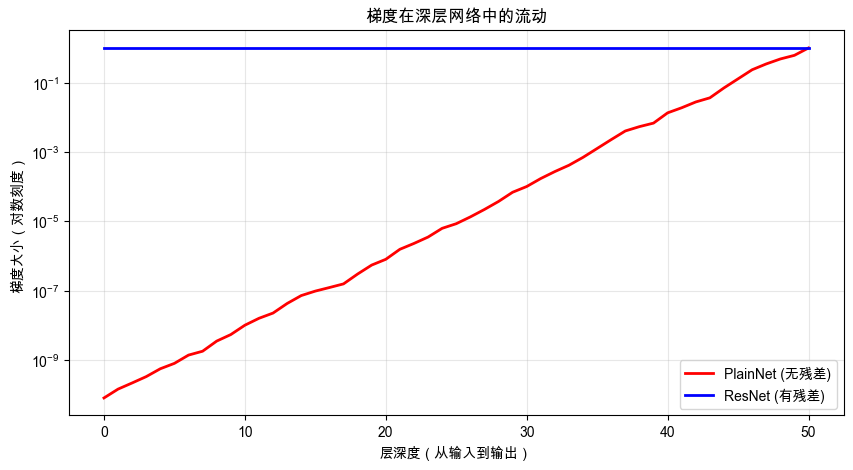

第1层梯度 - PlainNet: 7.94e-11, ResNet: 1.00e+00
梯度比值: ResNet / PlainNet = 12594806270倍


In [6]:
# 可视化：普通网络 vs 残差网络的梯度流

def simulate_gradient_flow(n_layers, with_residual=False):
    """模拟梯度在网络中的流动"""
    gradients = [1.0]  # 从输出层开始，梯度为1
    
    for _ in range(n_layers):
        # 假设每层的梯度衰减因子（0.5 表示梯度减半）
        layer_grad = 0.5 + 0.3 * np.random.rand()
        
        if with_residual:
            # 残差连接：梯度 = 层梯度 + 1（跳跃连接）
            # 但实际是乘法关系，简化为：min(层梯度 + 0.5, 1.0)
            new_grad = gradients[-1] * min(layer_grad + 0.5, 1.0)
        else:
            # 普通网络：梯度连乘，容易消失
            new_grad = gradients[-1] * layer_grad
        
        gradients.append(new_grad)
    
    return gradients[::-1]  # 反转，从输入层到输出层

# 模拟 50 层网络
n_layers = 50
np.random.seed(42)

grad_plain = simulate_gradient_flow(n_layers, with_residual=False)
grad_resnet = simulate_gradient_flow(n_layers, with_residual=True)

plt.figure(figsize=(10, 5))
plt.semilogy(range(n_layers + 1), grad_plain, 'r-', label='PlainNet (无残差)', linewidth=2)
plt.semilogy(range(n_layers + 1), grad_resnet, 'b-', label='ResNet (有残差)', linewidth=2)
plt.xlabel('层深度（从输入到输出）')
plt.ylabel('梯度大小（对数刻度）')
plt.title('梯度在深层网络中的流动')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"第1层梯度 - PlainNet: {grad_plain[0]:.2e}, ResNet: {grad_resnet[0]:.2e}")
print(f"梯度比值: ResNet / PlainNet = {grad_resnet[0] / grad_plain[0]:.0f}倍")

---

## 2.4 残差块的两种设计

### BasicBlock（用于 ResNet-18/34）

```
输入 x
  │
  ├──────────────────────────┐
  ↓                          │ (identity shortcut)
Conv 3×3 → BN → ReLU         │
  ↓                          │
Conv 3×3 → BN                │
  ↓                          │
  + ←────────────────────────┘
  ↓
ReLU
  ↓
输出
```

### Bottleneck（用于 ResNet-50/101/152）

```
输入 x
  │
  ├──────────────────────────┐
  ↓                          │ (identity shortcut)
Conv 1×1 → BN → ReLU  (降维)  │
  ↓                          │
Conv 3×3 → BN → ReLU  (提特征) │
  ↓                          │
Conv 1×1 → BN         (升维)  │
  ↓                          │
  + ←────────────────────────┘
  ↓
ReLU
  ↓
输出
```

**Bottleneck 的优势**：用 1×1 卷积先降维，减少 3×3 卷积的计算量，再升维恢复。

In [7]:
class BasicBlock(nn.Module):
    """
    ResNet 基础残差块（用于 ResNet-18/34）
    
    结构：
        x → Conv3×3 → BN → ReLU → Conv3×3 → BN → (+x) → ReLU
        
    参数：
        in_channels: 输入通道数
        out_channels: 输出通道数
        stride: 步幅（stride=2 时下采样）
    """
    
    # expansion 表示输出通道相对于中间层的倍数
    # BasicBlock 不改变通道数，所以 expansion=1
    expansion = 1
    
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        
        # ========================================
        # 主路径（残差函数 F(x)）
        # ========================================
        self.conv1 = nn.Conv2d(
            in_channels, out_channels, 
            kernel_size=3, stride=stride, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(
            out_channels, out_channels,
            kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # ========================================
        # 跳跃连接（shortcut）
        # ========================================
        # 当 stride != 1 或通道数改变时，需要调整 shortcut
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 
                         kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
    
    def forward(self, x):
        # 保存输入用于跳跃连接
        identity = self.shortcut(x)
        
        # 主路径
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        # 残差连接：F(x) + x
        out = out + identity
        
        # 最后的 ReLU
        out = F.relu(out)
        
        return out


# 测试 BasicBlock
print("BasicBlock 测试：")
block = BasicBlock(64, 64)
x = torch.randn(1, 64, 32, 32)
y = block(x)
print(f"  输入: {x.shape} → 输出: {y.shape}")

# 测试下采样情况
block_down = BasicBlock(64, 128, stride=2)
y_down = block_down(x)
print(f"  下采样: {x.shape} → 输出: {y_down.shape}")

BasicBlock 测试：
  输入: torch.Size([1, 64, 32, 32]) → 输出: torch.Size([1, 64, 32, 32])
  下采样: torch.Size([1, 64, 32, 32]) → 输出: torch.Size([1, 128, 16, 16])


---

## 2.5 完整 ResNet-18 实现

### ResNet-18 架构

```
输入 (3, 224, 224) 或 (3, 32, 32) for CIFAR

Conv 7×7, 64, stride=2 → BN → ReLU → MaxPool 3×3
  ↓
Layer1: [BasicBlock(64, 64)] × 2
  ↓
Layer2: [BasicBlock(64, 128, stride=2)] + [BasicBlock(128, 128)]
  ↓
Layer3: [BasicBlock(128, 256, stride=2)] + [BasicBlock(256, 256)]
  ↓
Layer4: [BasicBlock(256, 512, stride=2)] + [BasicBlock(512, 512)]
  ↓
AdaptiveAvgPool → Flatten → FC(512, num_classes)
```

**注意**：对于 CIFAR-10（32×32 图像），我们会简化初始层。

In [8]:
class ResNet18(nn.Module):
    """
    ResNet-18 完整实现
    
    适配 CIFAR-10（32×32）：简化初始层
    """
    
    def __init__(self, num_classes=10):
        super().__init__()
        
        # ========================================
        # 初始层（针对 CIFAR-10 简化）
        # ========================================
        # 原版 ImageNet：Conv 7×7, stride=2, MaxPool
        # CIFAR 简化版：Conv 3×3, stride=1, 无 MaxPool
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        
        # ========================================
        # 4 个残差层
        # ========================================
        self.layer1 = self._make_layer(64, 64, num_blocks=2, stride=1)
        self.layer2 = self._make_layer(64, 128, num_blocks=2, stride=2)
        self.layer3 = self._make_layer(128, 256, num_blocks=2, stride=2)
        self.layer4 = self._make_layer(256, 512, num_blocks=2, stride=2)
        
        # ========================================
        # 分类头
        # ========================================
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)
        
        # 权重初始化
        self._init_weights()
    
    def _make_layer(self, in_channels, out_channels, num_blocks, stride):
        """
        构建一个残差层（包含多个残差块）

        =====================================================================
        关键设计：stride 只作用于第一个块，后续块固定 stride=1
        =====================================================================

        为什么这样设计？
        ---------------
        每个 layer 只在「入口处」下采样一次，后续块在相同分辨率上堆叠，提取更深层特征。

        示例：layer2 = self._make_layer(64, 128, num_blocks=2, stride=2)

        ┌─────────────────────────────────────────────────────────────────┐
        │  Layer2 包含 2 个 BasicBlock                                    │
        ├─────────────────────────────────────────────────────────────────┤
        │                                                                 │
        │  第 1 个块: BasicBlock(64, 128, stride=2)  ← 使用传入的 stride  │
        │  ───────────────────────────────────────                        │
        │  作用: 「过渡块」                                               │
        │    - 通道数: 64 → 128  (翻倍)                                   │
        │    - 空间尺寸: 16×16 → 8×8  (减半，因为 stride=2)               │
        │                                                                 │
        │  第 2 个块: BasicBlock(128, 128, stride=1) ← 固定 stride=1      │
        │  ───────────────────────────────────────                        │
        │  作用: 「特征提取块」                                           │
        │    - 通道数: 128 → 128  (不变)                                  │
        │    - 空间尺寸: 8×8 → 8×8  (不变)                                │
        │                                                                 │
        └─────────────────────────────────────────────────────────────────┘

        如果每个块都用 stride=2 会怎样？（错误做法）

            (64, 16, 16) → (128, 8, 8) → (128, 4, 4)
                              块1            块2
                            stride=2       stride=2
                                ↑ 下采样太激进，信息丢失严重！

        正确做法（只在第一个块下采样）：

            (64, 16, 16) → (128, 8, 8) → (128, 8, 8)
                              块1            块2
                            stride=2       stride=1
                           「负责下采样」   「专注提特征」

        完整数据流（CIFAR-10，32×32 输入）：

            Layer1: (64, 32, 32)  →  (64, 32, 32)   stride=1, 尺寸不变
            Layer2: (64, 32, 32)  → (128, 16, 16)   stride=2, 尺寸减半
            Layer3: (128, 16, 16) → (256, 8, 8)    stride=2, 尺寸减半
            Layer4: (256, 8, 8)   → (512, 4, 4)    stride=2, 尺寸减半
        """
        layers = []

        # ========================================
        # 第一个块：负责「过渡」
        # - 改变通道数: in_channels → out_channels
        # - 可能下采样: 如果 stride=2，空间尺寸减半
        # ========================================
        layers.append(BasicBlock(in_channels, out_channels, stride))

        # ========================================
        # 后续块：在同一分辨率上「深挖」特征
        # - 通道数不变: out_channels → out_channels
        # - 尺寸不变: stride 固定为 1
        # ========================================
        for _ in range(1, num_blocks):
            layers.append(BasicBlock(out_channels, out_channels, stride=1))

        return nn.Sequential(*layers)
    
    def _init_weights(self):
        """Kaiming 初始化"""
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        # 初始层
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        
        # 4 个残差层
        x = self.layer1(x)  # 32×32 → 32×32
        x = self.layer2(x)  # 32×32 → 16×16
        x = self.layer3(x)  # 16×16 → 8×8
        x = self.layer4(x)  # 8×8 → 4×4
        
        # 分类头
        x = self.avgpool(x)  # 4×4 → 1×1
        x = torch.flatten(x, 1)
        x = self.fc(x)
        
        return x


# 测试 ResNet-18
model = ResNet18(num_classes=10)
x = torch.randn(2, 3, 32, 32)
y = model(x)
print(f"ResNet-18 测试：")
print(f"  输入: {x.shape}")
print(f"  输出: {y.shape}")
print(f"  参数量: {sum(p.numel() for p in model.parameters()):,}")

ResNet-18 测试：
  输入: torch.Size([2, 3, 32, 32])
  输出: torch.Size([2, 10])
  参数量: 11,173,962


---

## 2.6 对比实验：PlainNet vs ResNet

为了验证残差连接的效果，我们构建一个**没有残差连接的 PlainNet**，与 ResNet 对比。

In [9]:
class PlainBlock(nn.Module):
    """普通块：没有残差连接"""
    
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
    
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        # 没有残差连接！
        return out


class PlainNet18(nn.Module):
    """PlainNet-18：与 ResNet-18 结构相同，但没有残差连接"""
    
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, 1, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        
        self.layer1 = self._make_layer(64, 64, 2, 1)
        self.layer2 = self._make_layer(64, 128, 2, 2)
        self.layer3 = self._make_layer(128, 256, 2, 2)
        self.layer4 = self._make_layer(256, 512, 2, 2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)
    
    def _make_layer(self, in_ch, out_ch, num_blocks, stride):
        layers = [PlainBlock(in_ch, out_ch, stride)]
        for _ in range(1, num_blocks):
            layers.append(PlainBlock(out_ch, out_ch, 1))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        return self.fc(x)


print("PlainNet-18（无残差）参数量:", 
      f"{sum(p.numel() for p in PlainNet18().parameters()):,}")
print("ResNet-18（有残差）参数量:", 
      f"{sum(p.numel() for p in ResNet18().parameters()):,}")
print("\n💡 两者参数量相近，但性能差异巨大！")

PlainNet-18（无残差）参数量: 11,000,138
ResNet-18（有残差）参数量: 11,173,962

💡 两者参数量相近，但性能差异巨大！


In [12]:
# 训练函数
def train_model(model, train_loader, test_loader, epochs=5, lr=0.01):
    """训练模型并返回历史记录"""
    model = model.to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
    criterion = nn.CrossEntropyLoss()
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    
    history = {'train_acc': [], 'test_acc': []}
    
    for epoch in range(epochs):
        # 训练
        model.train()
        correct, total = 0, 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            correct += (out.argmax(1) == y).sum().item()
            total += y.size(0)
        train_acc = 100 * correct / total
        
        # 测试
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.to(device), y.to(device)
                out = model(x)
                print(f"x.shape: {x.shape}")           # (100, 3, 32, 32)
                print(f"y: {y[:10]}")                  # 前10个真实标签
                print(f"out.shape: {out.shape}")       # (100, 10)
                print(f"预测: {out.argmax(1)[:10]}")   # 前10个预测
                print(f"正确数: {(out.argmax(1) == y).sum().item()}")
                correct += (out.argmax(1) == y).sum().item()
                total += y.size(0)
        test_acc = 100 * correct / total
        
        history['train_acc'].append(train_acc)
        history['test_acc'].append(test_acc)
        print(f"Epoch {epoch+1}/{epochs}: Train Acc={train_acc:.1f}%, Test Acc={test_acc:.1f}%")
        
        scheduler.step()
    
    return history


# 加载 CIFAR-10 数据
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

print("加载 CIFAR-10 数据集...")
train_data = datasets.CIFAR10('./data', train=True, download=True, transform=transform_train)
test_data = datasets.CIFAR10('./data', train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_data, batch_size=128, shuffle=True, num_workers=2)
test_loader = DataLoader(test_data, batch_size=100, shuffle=False, num_workers=2)
print(f"训练集: {len(train_data)} 样本, 测试集: {len(test_data)} 样本")

加载 CIFAR-10 数据集...
Files already downloaded and verified
Files already downloaded and verified
训练集: 50000 样本, 测试集: 10000 样本


In [13]:
# 对比实验（训练 5 个 epoch 快速演示）
print("=" * 60)
print("对比实验：PlainNet-18 vs ResNet-18")
print("=" * 60)

EPOCHS = 5  # 为了快速演示，只训练 5 个 epoch

print("\n训练 PlainNet-18（无残差连接）...")
plain_model = PlainNet18()
plain_history = train_model(plain_model, train_loader, test_loader, epochs=EPOCHS)

print("\n训练 ResNet-18（有残差连接）...")
resnet_model = ResNet18()
resnet_history = train_model(resnet_model, train_loader, test_loader, epochs=EPOCHS)

# 绘制对比图
fig, ax = plt.subplots(figsize=(10, 5))
epochs_range = range(1, EPOCHS + 1)

ax.plot(epochs_range, plain_history['test_acc'], 'r-o', label='PlainNet-18', linewidth=2)
ax.plot(epochs_range, resnet_history['test_acc'], 'b-o', label='ResNet-18', linewidth=2)

ax.set_xlabel('Epoch')
ax.set_ylabel('Test Accuracy (%)')
ax.set_title('PlainNet vs ResNet：残差连接的效果')
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()

print(f"\n最终测试准确率：")
print(f"  PlainNet-18: {plain_history['test_acc'][-1]:.1f}%")
print(f"  ResNet-18:   {resnet_history['test_acc'][-1]:.1f}%")
print(f"  差距:        {resnet_history['test_acc'][-1] - plain_history['test_acc'][-1]:.1f}%")

对比实验：PlainNet-18 vs ResNet-18

训练 PlainNet-18（无残差连接）...


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x125982e50>
Traceback (most recent call last):
  File "/Users/lyh/miniconda3/envs/ml_env/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/Users/lyh/miniconda3/envs/ml_env/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1441, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/Users/lyh/miniconda3/envs/ml_env/lib/python3.8/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/Users/lyh/miniconda3/envs/ml_env/lib/python3.8/multiprocessing/popen_fork.py", line 44, in wait
    if not wait([self.sentinel], timeout):
  File "/Users/lyh/miniconda3/envs/ml_env/lib/python3.8/multiprocessing/connection.py", line 931, in wait
    ready = selector.select(timeout)
  File "/Users/lyh/miniconda3/envs/ml_env/lib/python3.8/selectors.py", line 415, in select
    fd_event_lis

KeyboardInterrupt: 

---

# Part 3: 现代架构趋势

> 下面将介绍两种重要的现代架构：EfficientNet 和 Vision Transformer，并通过代码演示如何使用。

## 概览

| 架构 | 年份 | 核心思想 | 特点 |
|------|------|----------|------|
| **EfficientNet** | 2019 | 复合缩放 | 效率与准确率兼顾 |
| **Vision Transformer** | 2020 | 图像 patch 化 | Transformer 架构 |

```
ResNet (2015) → EfficientNet (2019) → ViT (2020)
   ↑                  ↑                   ↑
  残差连接         复合缩放            Transformer
  突破深度        效率优化            新范式
```

---

## 3.1 EfficientNet 实战演示

EfficientNet 的核心是**复合缩放**：同时优化深度、宽度和分辨率。

In [14]:
# ============================================================
# EfficientNet 实战演示
# ============================================================

from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

# 1. 加载预训练模型
# ----------------------------------------------------------
# EfficientNet-B0 是最小的版本，适合入门
# B1 → B7 逐渐变大（更深、更宽、更高分辨率）

efficientnet = efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)
efficientnet.eval()

# 2. 查看模型结构
# ----------------------------------------------------------
print("EfficientNet-B0 结构概览：")
print("=" * 60)

# 统计各层类型
from collections import Counter
layer_types = Counter()
for name, module in efficientnet.named_modules():
    layer_types[type(module).__name__] += 1

print("\n各层类型统计：")
for layer_type, count in layer_types.most_common(10):
    print(f"  {layer_type}: {count}")

# 3. 与 ResNet-18 对比参数量
# ----------------------------------------------------------
resnet18_params = sum(p.numel() for p in ResNet18().parameters())
efficientnet_params = sum(p.numel() for p in efficientnet.parameters())

print(f"\n参数量对比：")
print(f"  ResNet-18:      {resnet18_params:>12,} 参数")
print(f"  EfficientNet-B0: {efficientnet_params:>12,} 参数")
print(f"  比例: EfficientNet / ResNet = {efficientnet_params / resnet18_params:.2f}x")

# 4. 查看分类头
# ----------------------------------------------------------
print(f"\n分类头：")
print(f"  EfficientNet-B0: {efficientnet.classifier}")
print(f"  输入特征: 1280 维 → 输出: 1000 类 (ImageNet)")

# 5. 简单推理演示
# ----------------------------------------------------------
dummy_input = torch.randn(1, 3, 224, 224)  # EfficientNet 需要 224×224 输入

with torch.no_grad():
    output = efficientnet(dummy_input)
    
print(f"\n推理演示：")
print(f"  输入: {dummy_input.shape}")
print(f"  输出: {output.shape}")
print(f"  预测类别: {output.argmax().item()}")

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /Users/lyh/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20.5M/20.5M [00:06<00:00, 3.33MB/s]


EfficientNet-B0 结构概览：

各层类型统计：
  Conv2d: 81
  Conv2dNormActivation: 49
  BatchNorm2d: 49
  SiLU: 49
  Sequential: 25
  AdaptiveAvgPool2d: 17
  MBConv: 16
  SqueezeExcitation: 16
  Sigmoid: 16
  StochasticDepth: 16

参数量对比：
  ResNet-18:        11,173,962 参数
  EfficientNet-B0:    5,288,548 参数
  比例: EfficientNet / ResNet = 0.47x

分类头：
  EfficientNet-B0: Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)
  输入特征: 1280 维 → 输出: 1000 类 (ImageNet)

推理演示：
  输入: torch.Size([1, 3, 224, 224])
  输出: torch.Size([1, 1000])
  预测类别: 21


### EfficientNet 系列对比

```
模型           | 参数量  | Top-1 准确率 | 输入分辨率
---------------|---------|-------------|----------
EfficientNet-B0| 5.3M    | 77.1%       | 224
EfficientNet-B1| 7.8M    | 79.1%       | 240
EfficientNet-B2| 9.2M    | 80.1%       | 260
EfficientNet-B3| 12M     | 81.6%       | 300
EfficientNet-B4| 19M     | 82.9%       | 380
EfficientNet-B5| 30M     | 83.6%       | 456
EfficientNet-B6| 43M     | 84.0%       | 528
EfficientNet-B7| 66M     | 84.3%       | 600
```

**复合缩放公式**：
- 深度：$d = \alpha^\phi$
- 宽度：$w = \beta^\phi$
- 分辨率：$r = \gamma^\phi$

约束：$\alpha \cdot \beta^2 \cdot \gamma^2 \approx 2$（计算量翻倍）

---

## 3.2 Vision Transformer (ViT) 实战演示

ViT 将图像切成 patch，像处理文本序列一样处理图像。

In [15]:
# ============================================================
# Vision Transformer (ViT) 实战演示
# ============================================================

from torchvision.models import vit_b_16, ViT_B_16_Weights

# 1. 加载预训练模型
# ----------------------------------------------------------
# ViT-B/16：Base 版本，patch size = 16×16
# 也有 ViT-L（Large）、ViT-H（Huge）等更大版本

vit = vit_b_16(weights=ViT_B_16_Weights.DEFAULT)
vit.eval()

# 2. 查看关键组件
# ----------------------------------------------------------
print("ViT-B/16 结构解析：")
print("=" * 60)

# Patch Embedding
print(f"\n1. Patch Embedding（将图像切成 patch）:")
print(f"   - 卷积核大小: {vit.conv_proj.kernel_size}")
print(f"   - 步幅: {vit.conv_proj.stride}")
print(f"   - 输出通道: {vit.conv_proj.out_channels}")
print(f"   → 224×224 图像 ÷ 16×16 patch = 14×14 = 196 个 patch")

# Class Token
print(f"\n2. Class Token:")
print(f"   - 形状: {vit.class_token.shape}")
print(f"   → 一个可学习的向量，代表整个图像的特征")

# Position Embedding
print(f"\n3. Position Embedding:")
print(f"   - 形状: {vit.encoder.pos_embedding.shape}")
print(f"   → 196 个 patch + 1 个 class token = 197 个位置")

# Transformer Encoder
num_layers = len(vit.encoder.layers)
print(f"\n4. Transformer Encoder:")
print(f"   - 层数: {num_layers}")
print(f"   - 隐藏维度: {vit.hidden_dim}")
print(f"   - 注意力头数: {vit.encoder.layers[0].self_attention.num_heads}")

# 3. 参数量对比
# ----------------------------------------------------------
vit_params = sum(p.numel() for p in vit.parameters())

print(f"\n参数量对比：")
print(f"  ResNet-18:       {resnet18_params:>12,}")
print(f"  EfficientNet-B0: {efficientnet_params:>12,}")
print(f"  ViT-B/16:        {vit_params:>12,}")
print(f"\n💡 ViT 参数量大很多，需要大量数据才能训练好")

# 4. 推理演示
# ----------------------------------------------------------
dummy_input = torch.randn(1, 3, 224, 224)  # ViT 需要 224×224 输入

with torch.no_grad():
    output = vit(dummy_input)
    
print(f"\n推理演示：")
print(f"  输入: {dummy_input.shape}")
print(f"  输出: {output.shape}")
print(f"  预测类别: {output.argmax().item()}")

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /Users/lyh/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 330M/330M [00:51<00:00, 6.74MB/s]


ViT-B/16 结构解析：

1. Patch Embedding（将图像切成 patch）:
   - 卷积核大小: (16, 16)
   - 步幅: (16, 16)
   - 输出通道: 768
   → 224×224 图像 ÷ 16×16 patch = 14×14 = 196 个 patch

2. Class Token:
   - 形状: torch.Size([1, 1, 768])
   → 一个可学习的向量，代表整个图像的特征

3. Position Embedding:
   - 形状: torch.Size([1, 197, 768])
   → 196 个 patch + 1 个 class token = 197 个位置

4. Transformer Encoder:
   - 层数: 12
   - 隐藏维度: 768
   - 注意力头数: 12

参数量对比：
  ResNet-18:         11,173,962
  EfficientNet-B0:    5,288,548
  ViT-B/16:          86,567,656

💡 ViT 参数量大很多，需要大量数据才能训练好

推理演示：
  输入: torch.Size([1, 3, 224, 224])
  输出: torch.Size([1, 1000])
  预测类别: 21


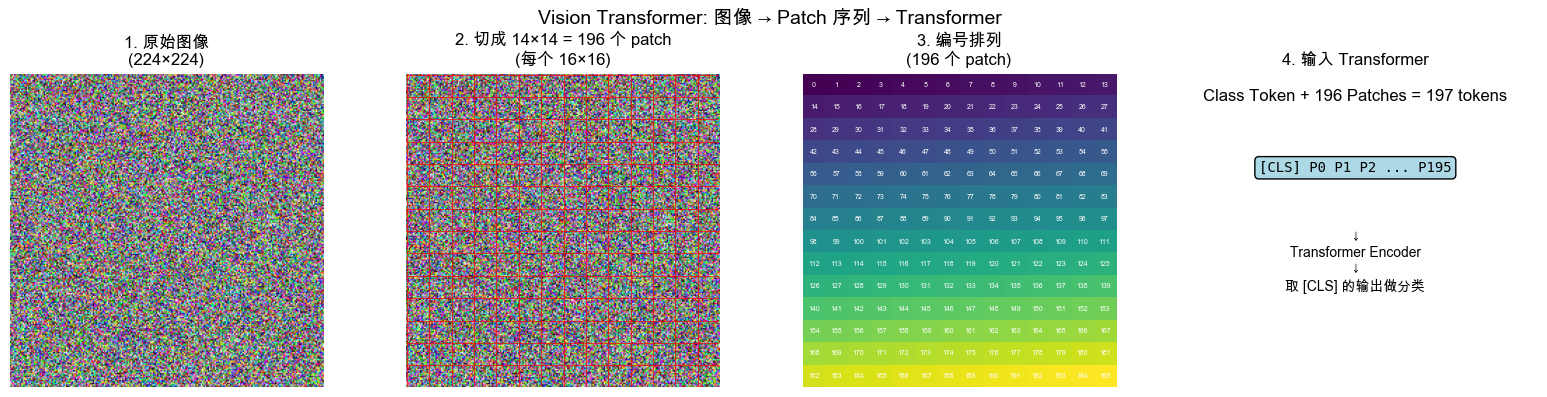

💡 ViT 的核心思想：
   - 把图像当作「文字序列」来处理
   - 每个 patch 相当于一个「词」
   - 用 Transformer 学习 patch 之间的关系


In [16]:
# 可视化 ViT 的 Patch Embedding 过程
# ----------------------------------------------------------

fig, axes = plt.subplots(1, 4, figsize=(16, 4))

# 1. 原始图像（模拟）
np.random.seed(42)
img = np.random.rand(224, 224, 3)
axes[0].imshow(img)
axes[0].set_title('1. 原始图像\n(224×224)')
axes[0].axis('off')

# 2. 切成 patch
patch_size = 16
for i in range(0, 224, patch_size):
    axes[1].axhline(y=i, color='red', linewidth=0.5)
    axes[1].axvline(x=i, color='red', linewidth=0.5)
axes[1].imshow(img)
axes[1].set_title(f'2. 切成 {224//patch_size}×{224//patch_size} = 196 个 patch\n(每个 16×16)')
axes[1].axis('off')

# 3. 展平成序列
patches = np.arange(196).reshape(14, 14)
im = axes[2].imshow(patches, cmap='viridis')
axes[2].set_title('3. 编号排列\n(196 个 patch)')
for i in range(14):
    for j in range(14):
        axes[2].text(j, i, str(patches[i, j]), ha='center', va='center', 
                     fontsize=5, color='white')
axes[2].axis('off')

# 4. 加上 class token
sequence = ['[CLS]'] + [f'P{i}' for i in range(196)]
axes[3].text(0.5, 0.95, 'Class Token + 196 Patches = 197 tokens', 
             ha='center', va='top', fontsize=12, transform=axes[3].transAxes)
axes[3].text(0.5, 0.7, '[CLS] P0 P1 P2 ... P195', 
             ha='center', va='center', fontsize=10, transform=axes[3].transAxes,
             family='monospace', bbox=dict(boxstyle='round', facecolor='lightblue'))
axes[3].text(0.5, 0.4, '↓\nTransformer Encoder\n↓\n取 [CLS] 的输出做分类', 
             ha='center', va='center', fontsize=10, transform=axes[3].transAxes)
axes[3].set_title('4. 输入 Transformer')
axes[3].axis('off')

plt.suptitle('Vision Transformer: 图像 → Patch 序列 → Transformer', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("💡 ViT 的核心思想：")
print("   - 把图像当作「文字序列」来处理")
print("   - 每个 patch 相当于一个「词」")
print("   - 用 Transformer 学习 patch 之间的关系")

---

## 3.3 架构选择指南

### 三大架构对比

三大架构对比

模型                               参数量  ImageNet Top-1
--------------------------------------------------
ResNet-18                    11.2M           69.8%
EfficientNet-B0               5.3M           77.1%
ViT-B/16                     86.6M           81.1%


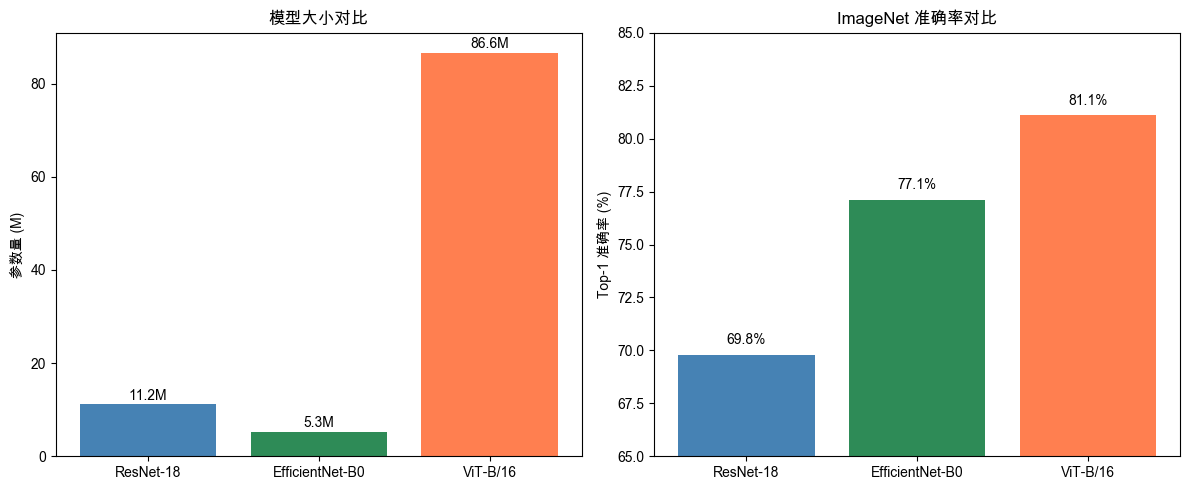


架构选择建议

| 场景                | 推荐架构              | 原因                        |
|---------------------|----------------------|----------------------------|
| 入门学习/教学       | ResNet-18/34         | 结构简洁，易于理解           |
| 小数据集 (<10K)     | 预训练 ResNet + 迁移  | 参数少，不易过拟合           |
| 中等数据集 (10K-1M) | EfficientNet-B0~B3   | 效率高，性能好              |
| 大数据集 (>1M)      | EfficientNet-B4~B7   | 充分利用大模型容量           |
| 超大数据集 + 资源   | ViT / Swin           | 最佳性能，但需要大量计算     |
| 移动端部署          | MobileNet / B0       | 小巧高效                    |
| 实时检测            | YOLO / EfficientDet  | 速度优化                    |

💡 实际工作中的建议：
   1. 先用 ResNet-18 + 预训练 做 baseline
   2. 如果效果不够，换 EfficientNet-B0~B3
   3. 资源充足 + 数据多，尝试 ViT
   4. 极少情况需要从零训练，优先用迁移学习


In [17]:
# ============================================================
# 三大架构对比总结
# ============================================================

# 1. 参数量和 FLOPs 对比
# ----------------------------------------------------------
print("=" * 70)
print("三大架构对比")
print("=" * 70)

# 计算参数量
models_info = {
    'ResNet-18': {
        'params': sum(p.numel() for p in ResNet18().parameters()),
        'input_size': 224,
        'top1': 69.8,  # ImageNet
    },
    'EfficientNet-B0': {
        'params': sum(p.numel() for p in efficientnet.parameters()),
        'input_size': 224,
        'top1': 77.1,
    },
    'ViT-B/16': {
        'params': sum(p.numel() for p in vit.parameters()),
        'input_size': 224,
        'top1': 81.1,
    },
}

print(f"\n{'模型':<20} {'参数量':>15} {'ImageNet Top-1':>15}")
print("-" * 50)
for name, info in models_info.items():
    params_m = info['params'] / 1e6
    print(f"{name:<20} {params_m:>12.1f}M {info['top1']:>14.1f}%")

# 2. 可视化对比
# ----------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

names = list(models_info.keys())
params = [info['params'] / 1e6 for info in models_info.values()]
top1 = [info['top1'] for info in models_info.values()]
colors = ['steelblue', 'seagreen', 'coral']

# 参数量
axes[0].bar(names, params, color=colors)
axes[0].set_ylabel('参数量 (M)')
axes[0].set_title('模型大小对比')
for i, v in enumerate(params):
    axes[0].text(i, v + 1, f'{v:.1f}M', ha='center')

# 准确率
axes[1].bar(names, top1, color=colors)
axes[1].set_ylabel('Top-1 准确率 (%)')
axes[1].set_title('ImageNet 准确率对比')
axes[1].set_ylim(65, 85)
for i, v in enumerate(top1):
    axes[1].text(i, v + 0.5, f'{v:.1f}%', ha='center')

plt.tight_layout()
plt.show()

# 3. 选择建议
# ----------------------------------------------------------
print("\n" + "=" * 70)
print("架构选择建议")
print("=" * 70)

recommendations = """
| 场景                | 推荐架构              | 原因                        |
|---------------------|----------------------|----------------------------|
| 入门学习/教学       | ResNet-18/34         | 结构简洁，易于理解           |
| 小数据集 (<10K)     | 预训练 ResNet + 迁移  | 参数少，不易过拟合           |
| 中等数据集 (10K-1M) | EfficientNet-B0~B3   | 效率高，性能好              |
| 大数据集 (>1M)      | EfficientNet-B4~B7   | 充分利用大模型容量           |
| 超大数据集 + 资源   | ViT / Swin           | 最佳性能，但需要大量计算     |
| 移动端部署          | MobileNet / B0       | 小巧高效                    |
| 实时检测            | YOLO / EfficientDet  | 速度优化                    |
"""
print(recommendations)

print("💡 实际工作中的建议：")
print("   1. 先用 ResNet-18 + 预训练 做 baseline")
print("   2. 如果效果不够，换 EfficientNet-B0~B3")
print("   3. 资源充足 + 数据多，尝试 ViT")
print("   4. 极少情况需要从零训练，优先用迁移学习")

---

## 📝 本章小结

### 核心知识点

1. **退化问题**：深层网络训练困难，不是过拟合，而是优化问题

2. **残差连接原理**：
   - 公式：$H(x) = F(x) + x$
   - 梯度：$\frac{\partial H}{\partial x} = \frac{\partial F}{\partial x} + 1$ ← 至少为 1

3. **残差块设计**：
   - BasicBlock：两层 3×3 卷积（ResNet-18/34）
   - Bottleneck：1×1 → 3×3 → 1×1（ResNet-50+）

4. **现代趋势**：EfficientNet（效率）、ViT（Transformer）

### 关键代码

```python
# 残差连接的核心（一行代码）
out = F.relu(self.bn2(self.conv2(out)) + identity)
```

---

## 🚀 下一步

继续学习 **08_transfer_learning.ipynb** - 迁移学习

学习如何使用预训练的 ResNet 模型，在自己的数据集上微调。